In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda, Input
from tensorflow.keras.models import Model
plt.style.use('default')
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('TSLA.csv')
print(df.shape)
df.head()

(2416, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


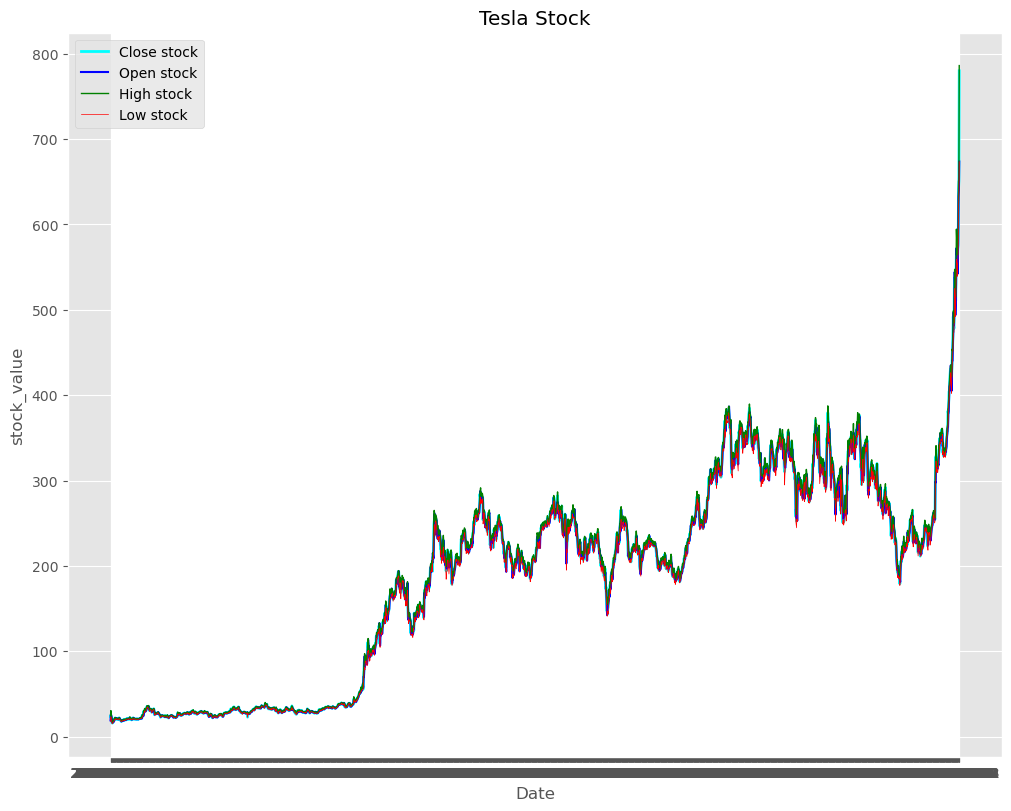

In [3]:
plt.figure(figsize=(10, 8), constrained_layout=True)
c = ['cyan', 'blue', 'green', 'red']
y = ['Close', 'Open', 'High', 'Low']
l = 2.0
for j, c in zip(y, c):
  plt.plot(df['Date'], df[j], color=c, linewidth=l, label=f'{j} stock')
  plt.title('Tesla Stock')
  plt.xlabel('Date')
  plt.ylabel('stock_value')
  plt.legend()
  l -=0.5

plt.show()

In [4]:
from PyEMD import CEEMDAN, Visualisation

In [5]:
close = df[['Close']].values

In [6]:
close

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [640.809998],
       [650.570007],
       [780.      ]])

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
close_norm = scaler.fit_transform(close)
close_norm

array([[0.01058623],
       [0.01050772],
       [0.00806072],
       ...,
       [0.81786181],
       [0.83063335],
       [1.        ]])

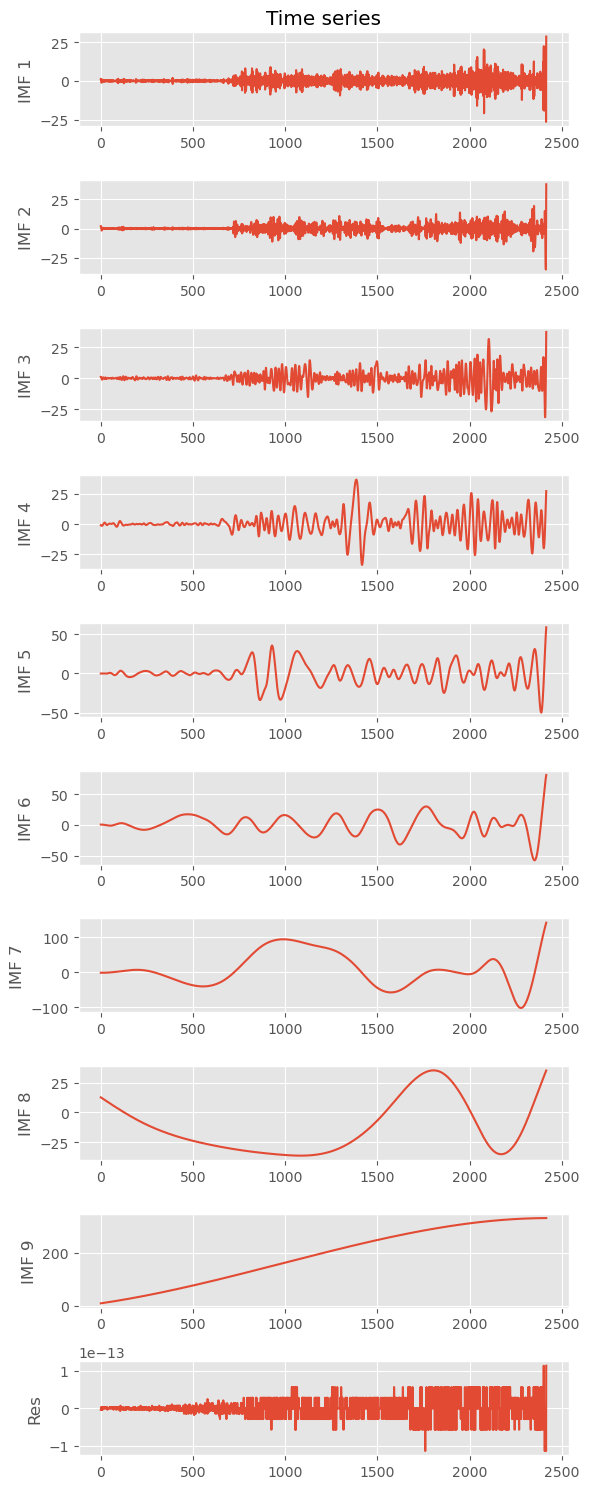

In [6]:
ceemdan = CEEMDAN()
ceemdan.ceemdan(close.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, 2416, 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [11]:
imfs_close[1][2400:2440]

array([ -1.13749601,   0.59577737,   1.48986297,  -1.83562631,
        -4.68758346,  -2.33326495,   6.96532623,  15.12446972,
        15.26797543,   5.72340519,  -8.86732749, -21.81095523,
       -30.40376187, -34.92318589,  -7.13925342,  37.56693438])

In [7]:
# 取之前X_lag个数据来预测下一个数据
def time_slice(data,X_lag):
    sample = []
    label = []
    for k in range(len(data) - X_lag - 1):
        t = k + X_lag
        sample.append(data[k:t])
        label.append(data[t + 1])
    return sample,label


In [ ]:
def split(sample, label, test_ratio):
    length = len(label)
    train_len = round((1-test_ratio)*length)
    X_train = sample[0:train_len]
    X_test = sample[train_len+1:length]
    y_train = label[0:train_len]
    y_test = label[train_len+1:length]
    
    return X_train, X_test, y_train, y_test

In [8]:
import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
def implement_LSTM(X_train, y_train):
    model = Sequential()
    model.add(LSTM(15, input_shape=(None,1)))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
#     model.compile(loss='mean_squared_error', optimizer='sgd')
    model.fit(X_train, y_train, epochs=350, batch_size=16, verbose=0)
    
    return model

In [11]:
i = 1
svr = []
prediction = []
actual = []

for imf in imfs_close:
#     print('-'*45)
#     print('This is  ' + str(i)  + '  time(s)')
#     print('*'*45)
    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.asarray(X_test)
    X_test = np.expand_dims(X_test, axis=2)
#     y_train = np.expand_dims(y_train, axis=3)
    
    tmp = implement_LSTM(X_train, y_train)
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    i=i+1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                1020      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
________

In [15]:
pre_tmp = svr[0].predict(X_test)
pre_tmp

array([[-1.34429777e+00],
       [ 4.37663984e+00],
       [ 5.22752714e+00],
       [-2.84822941e-01],
       [ 3.98082793e-01],
       [-8.44101906e-02],
       [ 8.14825296e-02],
       [ 3.63069391e+00],
       [-3.11308908e+00],
       [ 9.00189281e-01],
       [-9.52764869e-01],
       [ 1.57910526e+00],
       [ 1.73732531e+00],
       [ 9.49375570e-01],
       [-1.81755054e+00],
       [ 5.68501949e-02],
       [ 7.29579210e-01],
       [-2.65447521e+00],
       [-1.58168566e+00],
       [ 8.84541273e-02],
       [ 2.68424809e-01],
       [-6.32273078e-01],
       [-1.63616884e+00],
       [-4.36920023e+00],
       [ 3.31036091e-01],
       [-4.08821392e+00],
       [ 1.71523070e+00],
       [ 5.91342115e+00],
       [-2.44667912e+00],
       [-2.71306872e-01],
       [-2.11203337e+00],
       [-1.66515112e-02],
       [ 1.14136958e+00],
       [-6.68578267e-01],
       [ 1.84624553e+00],
       [-1.30020380e-02],
       [-7.58531094e-02],
       [-2.77200556e+00],
       [ 2.1

In [41]:
prediction

[array([[ 8.95848572e-01],
        [-3.62085223e-01],
        [-4.62277472e-01],
        [-7.66573906e+00],
        [ 1.44034065e-03],
        [-9.79540423e-02],
        [ 7.38836467e-01],
        [ 1.97447979e+00],
        [-2.68000007e+00],
        [-1.35903712e-02],
        [-6.30436987e-02],
        [-6.79612637e-01],
        [ 4.32369739e-01],
        [-1.70220089e+00],
        [-4.11411047e-01],
        [-6.15266338e-02],
        [ 1.22113264e+00],
        [-3.78114909e-01],
        [ 2.48406219e+00],
        [-3.13440967e+00],
        [-8.24763551e-02],
        [-2.78261125e-01],
        [-1.44770396e+00],
        [ 1.18935309e-01],
        [-4.62949067e-01],
        [ 2.94059396e+00],
        [ 3.08531493e-01],
        [ 1.19021177e+00],
        [ 6.49260700e-01],
        [-2.37852689e-02],
        [-3.54224896e+00],
        [-7.34776780e-02],
        [ 4.86476034e-01],
        [-1.64654821e-01],
        [-5.32309341e+00],
        [-1.81604588e+00],
        [ 7.74729475e-02],
 

In [12]:
mean_pre = []

for i in range(0,len(prediction[0])):
    sum = 0
    for j in range(0,len(prediction)):
        sum = sum + prediction[j][i]
    
    mean = sum/len(prediction) 
    mean_pre.append(mean)
        
mean_pre        

[array([27.80468], dtype=float32),
 array([28.031563], dtype=float32),
 array([24.505089], dtype=float32),
 array([34.296], dtype=float32),
 array([3.8634257], dtype=float32),
 array([3.4483347], dtype=float32),
 array([14.136376], dtype=float32),
 array([24.872768], dtype=float32),
 array([24.624146], dtype=float32),
 array([3.0207467], dtype=float32),
 array([25.310825], dtype=float32),
 array([35.318096], dtype=float32),
 array([25.596964], dtype=float32),
 array([12.959817], dtype=float32),
 array([28.73035], dtype=float32),
 array([3.035063], dtype=float32),
 array([27.259165], dtype=float32),
 array([25.087082], dtype=float32),
 array([20.213968], dtype=float32),
 array([46.628662], dtype=float32),
 array([3.2731082], dtype=float32),
 array([3.7591548], dtype=float32),
 array([34.19993], dtype=float32),
 array([22.986477], dtype=float32),
 array([32.7373], dtype=float32),
 array([41.386074], dtype=float32),
 array([35.160816], dtype=float32),
 array([30.28517], dtype=float32),
 a

In [13]:
mean_actual = []

for i in range(0,len(actual[0])):
    sum = 0
    for j in range(0,len(actual)):
        sum = sum + actual[j][i]
    
    mean = sum/len(actual)
    mean_actual.append(mean)
        
mean_actual    

[27.657777555555555,
 27.952222999999996,
 24.283333666666667,
 34.30444333333333,
 3.824444222222222,
 3.478888777777778,
 14.433332666666665,
 25.223332777777777,
 25.00111055555556,
 2.9633333333333334,
 25.191111222222222,
 34.50555422222222,
 25.69777766666667,
 12.804444222222223,
 27.85333255555556,
 3.073333333333333,
 27.12222288888889,
 24.728888666666663,
 20.418889333333336,
 46.580000111111104,
 3.275555555555555,
 3.7422222222222223,
 35.04444377777778,
 22.807778222222225,
 32.248887777777774,
 40.26333277777778,
 34.58222111111111,
 30.362223333333336,
 25.827777444444443,
 22.307778222222222,
 29.94333222222222,
 2.3788888888888886,
 19.69000077777778,
 19.678889,
 26.03777733333333,
 34.89666744444445,
 3.7533332222222224,
 30.55666777777778,
 3.5044445555555543,
 27.492221444444446,
 23.34333288888889,
 39.19666544444445,
 25.044443777777776,
 29.718889000000004,
 21.978888666666666,
 27.019999222222225,
 39.821112777777785,
 3.1777777777777776,
 24.982221777777777,


In [14]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(mean_actual, mean_pre))
print("mean_squared_error:", mean_squared_error(mean_actual, mean_pre))
print("rmse:", sqrt(mean_squared_error(mean_actual, mean_pre)))
print("r2 score:", r2_score(mean_actual, mean_pre))

mean_absolute_error: 0.2960618897009104
mean_squared_error: 0.2406928267789987
rmse: 0.4906045523423103
r2 score: 0.9986717358634194


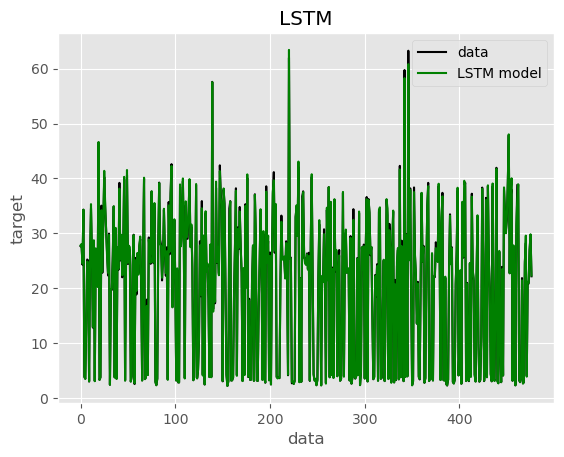

In [15]:
plt.plot(mean_actual,c='k',label='data')
plt.plot(mean_pre,c='g',label='LSTM model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('LSTM')
plt.legend()
plt.show()
